In [89]:
'''
Reconstruction helical data using parallel conebeam rebinning
'''

'\nReconstruction helical data using parallel conebeam rebinning\n'

In [90]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

import ct_projector.projector.numpy as ct_projector
import ct_projector.projector.numpy.helical_equiangular_parallel_rebin as ct_helical

import importlib
importlib.reload(ct_helical)

<module 'ct_projector.projector.numpy.helical_equiangular_parallel_rebin' from '/home/local/PARTNERS/dw640/CTProjector/src/ct_projector/projector/numpy/helical_equiangular_parallel_rebin.py'>

In [91]:
input_filename = '54_1.mat'

with h5py.File(input_filename, 'r') as f:
    # if a view is valid
    view_valid_a = np.copy(f['sh']['Lookup']['DetA']).flatten()
    view_valid_b = np.copy(f['sh']['Lookup']['DetB']).flatten()
    
    # z position of the source for each view, convert to mm
    zpos_a = np.copy(f['posA']).flatten() / 1000
    zpos_b = np.copy(f['posB']).flatten() / 1000
    
    # angle of the source for each view, convert to radius
    angles_a = np.copy(f['angleA']).flatten() / 180 * np.pi
    angles_b = np.copy(f['angleB']).flatten() / 180 * np.pi
    
    # projection, convert to attenuation
    prjs_a = np.copy(np.copy(f['projA'])[:, ::-1, :], 'C').astype(np.float32) / 2294.5
    prjs_b = np.copy(np.copy(f['projB'])[:, ::-1, :], 'C').astype(np.float32) / 2294.5

In [92]:
projector = ct_projector.ct_projector()
projector.nv = prjs_a.shape[1]
projector.dso = 595
projector.du = 0.067864004196156 * np.pi / 180 * projector.dsd
projector.dv = 1.0947
projector.off_u = -1.25
projector.rotview = 1152
dtheta = np.pi * 2 / projector.rotview

projector.nu = prjs_a.shape[2]
projector_rebin_a, prjs_rebin_a, angles_a, zrot_a, nview_margin_pre_a, nview_margin_post_a = \
    ct_helical.rebin_helical_to_parallel(projector, prjs_a, angles_a, zpos_a)

projector.nu = prjs_b.shape[2]
projector_rebin_b, prjs_rebin_b, angles_b, zrot_b, nview_margin_pre_b, nview_margin_post_b = \
    ct_helical.rebin_helical_to_parallel(projector, prjs_b, angles_b, zpos_b)

Beta (fan angle) interpolation...
100,200,300,400,500,600,700,
Theta (source angle) interpolation...
100,200,300,400,500,600,700,
Beta (fan angle) interpolation...
100,200,300,400,
Theta (source angle) interpolation...
100,200,300,400,


In [93]:
istart_origin_a = np.where(view_valid_a > 0.5)[0][0]
istart_origin_b = np.where(view_valid_b > 0.5)[0][0]
first_angle_offset = istart_origin_b - istart_origin_a
print(first_angle_offset)

304


In [94]:
prjs_rebin_ab, istart_a, istart_b = ct_helical.pad_dual_source_ct_rebinned_projection(
    projector_rebin_a,
    projector_rebin_b,
    prjs_rebin_a,
    prjs_rebin_b,
    angles_a,
    angles_b,
    zrot_a,
    zrot_b,
    first_angle_offset,
    nview_margin_pre_a,
    nview_margin_pre_b,
    nview_margin_post_a,
    nview_margin_post_b,
)

In [95]:
ct_projector.set_device(1)
img_a = ct_helical.fbp_long(
    projector_rebin_a,
    prjs_rebin_ab[[0]],
    angles_a[istart_a],
    zpos_a[istart_a],
    zrot_a
)

In [96]:
img_b = ct_helical.fbp_long(
    projector_rebin_b,
    prjs_rebin_ab[[1]],
    angles_b[istart_b],
    zpos_b[istart_b],
    zrot_b
)

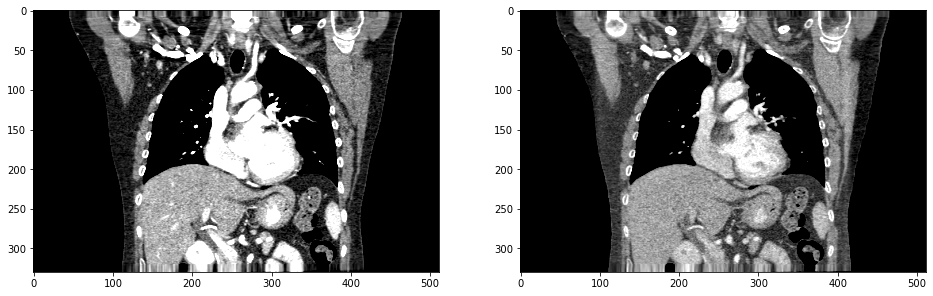

In [112]:
plt.figure(figsize=[16, 8])
plt.subplot(121)
plt.imshow(img_a[..., ::-1][0, :, 256, :], 'gray', vmin=0.01596, vmax=0.02356)
plt.subplot(122)
plt.imshow(img_b[..., ::-1][0, :, 256, :], 'gray', vmin=0.01596, vmax=0.02356)

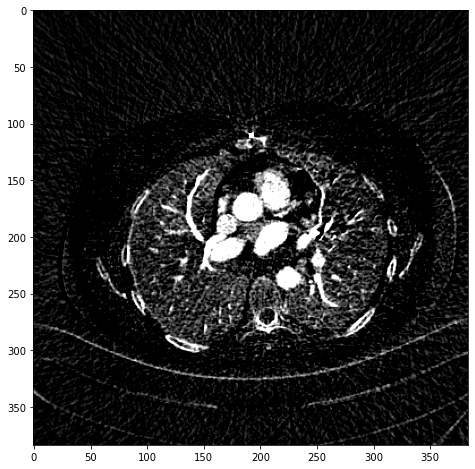

In [114]:
diff = (img_a - img_b) / 0.019 * 1000
plt.figure(figsize=[8, 8])
plt.imshow(diff[..., ::-1][0, 145, 64:-64, 64:-64], 'gray', vmin=0, vmax=250)

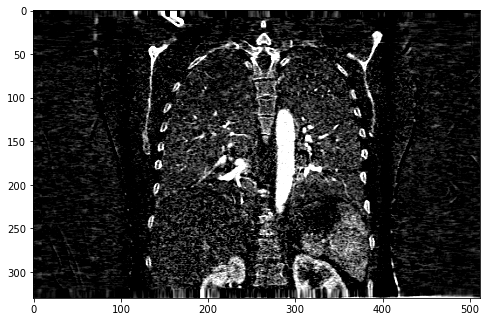

In [113]:
plt.figure(figsize=[8, 8])
plt.imshow(diff[..., ::-1][0, :, 300, :], 'gray', vmin=0, vmax=250)